# Quantum Beat Generator Tutorial

Welcome to this tutorial! In this notebook, we will explore Quiko and its innovative ability to create new beats. At a high level, Quiko works by comparing a given input with a database of samples and determining which sample should play at each beat of a musical measure. The process is visualized in the following diagram:

<img src="https://drive.google.com/uc?id=1eXnnuXKlN8lkbY6PZXiPwaHySee9clnL" alt="Description" width="700">


This notebook is designed with Google Colab in mind, allowing for a seamless experience while running the provided code.

## Step 1: Load the Repository

To get started, we’ll first load the repository. This step ensures we can easily access and execute its functions throughout the tutorial. And also install the necessary libraries for execution.

In [1]:
!!git clone https://github.com/MaiolSabater/Quantum-Music.git
!pip install qiskit
!pip install qiskit_aer
!pip install pydub

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 14.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.4/119.4 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 26.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.7/49.7 MB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.5/108.5 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 56.6 MB/s eta 0:00:00


In [2]:
import sys
# Add the folder path to Python's system path
sys.path.append('Quantum-Music')

## Step 2:Database Samples Processing

The first step is to load the necessary data. For this project, we’ll use the **9th Wonder Sound Pack** to construct our database. These database samples will be compared against the input sample to determine which ones will be played in the output track.

To load the database, start by downloading it using the following command:

In [3]:
!gdown https://drive.google.com/uc?id=1fmpWqW7Mta8PTR3AOXecG-HTb_Lsfbyx
!unzip 9th_Wonder_Drum_Kit.zip

Downloading...
From: https://drive.google.com/uc?id=1fmpWqW7Mta8PTR3AOXecG-HTb_Lsfbyx
To: /content/9th_Wonder_Drum_Kit.zip
100% 22.2M/22.2M [00:00<00:00, 24.1MB/s]
Archive:  9th_Wonder_Drum_Kit.zip
   creating: 9th Wonder Drum Kit/
   creating: 9th Wonder Drum Kit/Claps/
  inflating: 9th Wonder Drum Kit/Claps/Bg_Clp.wav  
  inflating: 9th Wonder Drum Kit/Claps/Crk_Clp.wav  
  inflating: 9th Wonder Drum Kit/Claps/Hnd_Clp2.wav  
  inflating: 9th Wonder Drum Kit/Claps/Lad_Clp.wav  
  inflating: 9th Wonder Drum Kit/Claps/Mpl_Clp.wav  
  inflating: 9th Wonder Drum Kit/Claps/Mxr_Clp.wav  
  inflating: 9th Wonder Drum Kit/Claps/Nc_Clp.wav  
  inflating: 9th Wonder Drum Kit/Claps/Ol_Clp.wav  
  inflating: 9th Wonder Drum Kit/Claps/Osc_Clp.wav  
  inflating: 9th Wonder Drum Kit/Claps/Phn_Clp.wav  
  inflating: 9th Wonder Drum Kit/Claps/Pil_Clp.wav  
  inflating: 9th Wonder Drum Kit/Claps/Sml_Clp1.wav  
  inflating: 9th Wonder Drum Kit/Claps/Sml_Clp2.wav  
  inflating: 9th Wonder Drum Kit/Claps/

The next step is to build a bundle of Quantum circuits. The purpose of this step is to pre-build these circuits, which saves time when executing code later. Each sample in the database will have its own dedicated circuit. These circuits will output a vector state upon measurement, which will be compared with the input sample values.

To construct the bundle, each sample is passed through a **filter bank** to separate it into three subbands: **low**, **mid**, and **high frequencies**. Once these subbands are obtained, the **Harmonic-Percussive Source Separation (HPSS)** algorithm is applied, which separates the **Harmonic** and **Percussive** elements of each subband. These elements provide the necessary parameters for building the Quantum circuits.

⚠️ **Note:** This process might take a few minutes to complete.

In [4]:
def save_database_bundle(database_bundle, names, folder_list, save_directory="./Database"):
    """
    Save each quantum circuit in the database_bundle to .qpy files organized by folder.

    Args:
        database_bundle (list): List of quantum circuits.
        names (list): List of track names corresponding to each circuit.
        folder_list (list): List of folders each track belongs to (e.g., 'hit-hats' or 'shakers').
        save_directory (str): Main directory to save the organized database.
    """
    if not os.path.exists(save_directory):
        os.makedirs(save_directory)

    # Dictionary to hold track names and file paths
    circuit_paths = {}

    # Loop through each circuit, track name, and corresponding folder
    for circuit, track_name, folder in zip(database_bundle, names, folder_list):
        # Define subfolder path based on the track's folder
        folder_path = os.path.join(save_directory, folder)
        if not os.path.exists(folder_path):
            os.makedirs(folder_path)

        # Define file path for each circuit in its respective subfolder
        circuit_path = os.path.join(folder_path, f"{track_name}.qpy")

        # Save the circuit as .qpy
        with open(circuit_path, "wb") as file:
            qpy.dump(circuit, file)

        # Store the file path in a dictionary for reference
        circuit_paths[track_name] = circuit_path

    # Save circuit paths to a JSON file in the main save directory
    json_path = os.path.join(save_directory, "database_bundle_paths.json")
    with open(json_path, "w") as json_file:
        json.dump(circuit_paths, json_file)

    print(f"Database bundle saved to {save_directory}")

def load_database_bundle(load_directory="./Database"):
    """
    Load database_bundle from saved .qpy files organized by subfolders.

    Args:
        load_directory (str): Main directory containing the saved database with subfolders.

    Returns:
        tuple: (circuit_bundle, track_names)
            - circuit_bundle (list): List of loaded quantum circuits.
            - track_names (list): List of track names corresponding to each circuit.
    """
    # Path to JSON file containing paths for each track's .qpy file
    json_path = os.path.join(load_directory, "database_bundle_paths.json")

    # Load the JSON file with circuit paths
    with open(json_path, "r") as json_file:
        circuit_paths = json.load(json_file)

    # Lists to hold loaded circuits and track names
    circuit_bundle = []
    track_names = []

    # Load each circuit from its .qpy file path stored in circuit_paths
    for track_name, circuit_path in circuit_paths.items():
        # Construct the full path
        full_path = circuit_path
        # Load the circuit from the .qpy file
        with open(full_path, "rb") as file:
            loaded_circuit = qpy.load(file)[0]  # qpy.load returns a list of circuits

            # Append to lists
            circuit_bundle.append(loaded_circuit)
            track_names.append(track_name)

    print("Database bundle loaded successfully from organized subfolders.")
    return circuit_bundle, track_names

In [5]:
#Init_Database function will initialize the database
from Quiko_Preprocessing import samp_subband, sample_database, Init_Database
import json
import qiskit
from qiskit import QuantumCircuit
from qiskit import qpy  # for qpy serialization
import sys
import os
import argparse
import numpy as np
import random

#Filter Bank
subB = {2:[1080], # this is the 2-qubit case
        3:[920, 3150], # This is for the 3-qubit case
        4:[630, 1720,  4400], # This is for the 4-qubit case
        5:[510, 1270, 2700, 6400], # This is for the 5-qubit case
        6:[400, 920, 1720, 3150, 6400], # This is for the 6-qubit case
        8:[300, 630, 1080, 1720, 2700, 4400, 7700], # This is for the 8-qubit case
        12:[200, 400, 630, 920, 1270, 1720, 2320, 3150, 4400, 6400, 9500], # This is for the 12-qubit case
        25:[100, 200, 300, 400, 510, 630, 770, 920, 1080, 1270, 1480, 1720, 2000, 2320, 2700, 3150, 3700, 4400, 5300, 6400, 7700, 9500, 12000, 15500]} # This is for the 25-qubit case

#Set the seed
seed = 41

np.random.seed(seed)
random.seed(seed)


#Set the number of subbands and the mapping
num_bands = 3
band_mapping = subB[num_bands]

# Directory containing drum samples
folder = './' #check claps for debugging

backend = 'aer_simulator'  # Local simulator or real device if preferred
boundle, names, folder_list = Init_Database(num_bands, band_mapping, folder, backend)

print('------------------------------------')
save_database_bundle(boundle, names, folder_list)

/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1977
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1536
  warnings.warn(


Encoding parameters:
Encoding qubit 0 with parameters [2.873, 0.436, 1343.6]
Encoding qubit 1 with parameters [0.341, 0.135, 3158.327]
Encoding qubit 2 with parameters [0.08, 0.044, 1946.429]
Encoding parameters:
Encoding qubit 0 with parameters [0.737, 0.339, 188.493]
Encoding qubit 1 with parameters [0.149, 0.156, 199.184]
Encoding qubit 2 with parameters [0.049, 0.054, 84.636]
Encoding parameters:
Encoding qubit 0 with parameters [2.037, 0.59, 863.113]
Encoding qubit 1 with parameters [0.36, 0.163, 395.116]
Encoding qubit 2 with parameters [0.088, 0.057, 112.42]
Encoding parameters:
Encoding qubit 0 with parameters [0.534, 0.458, 191.747]
Encoding qubit 1 with parameters [0.126, 0.127, 241.857]
Encoding qubit 2 with parameters [0.072, 0.039, 274.827]
Encoding parameters:
Encoding qubit 0 with parameters [5.141, 0.615, 2783.505]
Encoding qubit 1 with parameters [0.588, 0.174, 928.766]
Encoding qubit 2 with parameters [0.295, 0.04, 251.984]
Encoding parameters:
Encoding qubit 0 with p

Once the Quantum circuit bundle has been constructed, a new folder called **Database** will be created. This folder will contain all the database circuits, fully prepared and ready for execution.

With these steps completed, the database is now ready to be processed and compared with the **Input Sample**.

## Step 3: Input Sample Processing

In this section, we will process the **Input Sample**. The first step is to preprocess the sample and map it into a Quantum circuit. Since we will only be working with **one measure**, we do not need the entire audio track—just a single measure of the input sample.

To achieve this, we will use the **librosa** library to extract the **Beats Per Minute (BPM)**. Using the BPM, we can calculate the duration of one measure in seconds and crop the corresponding section from the audio file.


The code below will download **20 hip-hop tracks** from the **GTZAN dataset**. Only 20 tracks are downloaded to minimize processing time for the demo.

If you’d like to use your own songs instead, you can simply upload a folder containing your tracks and update the file path in the `extract_measure_from_folder` function.

In [17]:
!gdown https://drive.google.com/uc?id=1ofxTZhQm2jIJncZ_byHQlvv1wuH0lu2w
!unzip 10_hiphop.zip

Downloading...
From (original): https://drive.google.com/uc?id=1ofxTZhQm2jIJncZ_byHQlvv1wuH0lu2w
From (redirected): https://drive.google.com/uc?id=1ofxTZhQm2jIJncZ_byHQlvv1wuH0lu2w&confirm=t&uuid=dcb6096f-1545-41b5-bfab-24cc57e68895
To: /content/10_hiphop.zip
100% 26.7M/26.7M [00:00<00:00, 31.2MB/s]
Archive:  10_hiphop.zip
  inflating: hiphop/hiphop.00000.wav  
  inflating: hiphop/hiphop.00001.wav  
  inflating: hiphop/hiphop.00002.wav  
  inflating: hiphop/hiphop.00003.wav  
  inflating: hiphop/hiphop.00004.wav  
  inflating: hiphop/hiphop.00005.wav  
  inflating: hiphop/hiphop.00006.wav  
  inflating: hiphop/hiphop.00007.wav  
  inflating: hiphop/hiphop.00008.wav  
  inflating: hiphop/hiphop.00009.wav  
  inflating: hiphop/hiphop.00010.wav  
  inflating: hiphop/hiphop.00011.wav  
  inflating: hiphop/hiphop.00012.wav  
  inflating: hiphop/hiphop.00013.wav  
  inflating: hiphop/hiphop.00014.wav  
  inflating: hiphop/hiphop.00015.wav  
  inflating: hiphop/hiphop.00016.wav  
  inflating:

In [21]:
import os
from pydub import AudioSegment
import librosa
import numpy as np
def extract_measure_from_folder(input_folder, output_folder):

    """
    This function processes audio files within a folder and extracts a measure
    (a fixed duration of audio based on the tempo) from each file. It saves the
    extracted measure in a corresponding folder structure within a specified
    output directory.
    """

    # Loop through the directory tree
    for root, dirs, files in os.walk(input_folder):
        # Calculate the relative path from the input folder
        relative_path = os.path.relpath(root, input_folder)
        # Create the corresponding folder in the output directory
        output_subfolder = os.path.join(output_folder, relative_path)
        os.makedirs(output_subfolder, exist_ok=True)

        # Process each file in the current directory
        for filename in files:
            # Get the full file path
            file_path = os.path.join(root, filename)

            # Check if the file is a valid audio file
            if filename.endswith(('.mp3', '.wav', '.flac', '.ogg')):
                try:
                    # Load the audio file using librosa to calculate tempo
                    y, sr = librosa.load(file_path, sr=None)

                    # Estimate tempo (in beats per minute)
                    tempo_array, _ = librosa.beat.beat_track(y=y, sr=sr)

                    # Explicitly extract the first tempo value
                    tempo = float(tempo_array[0]) if isinstance(tempo_array, (list, np.ndarray)) else tempo_array

                    # Print the estimated tempo
                    print(f"Estimated tempo for {filename}: {tempo:.2f} BPM")

                    # Calculate measure duration (4 beats per measure, 60 seconds per minute)
                    measure_duration = (60 / tempo) * 4  # seconds

                    # Load the audio with pydub for easier slicing
                    audio = AudioSegment.from_file(file_path)

                    # Convert measure duration from seconds to milliseconds
                    measure_duration_ms = int(measure_duration * 1000)

                    # Extract the measure duration from the start of the audio
                    measure_audio = audio[:measure_duration_ms]

                    # Create the output file path
                    output_file_path = os.path.join(output_subfolder, filename)

                    # Export the measure to the new file
                    measure_audio.export(output_file_path, format="mp3")
                    print(f"Processed {file_path} - Extracted {measure_duration_ms} ms")

                except Exception as e:
                    print(f"Error processing {file_path}: {e}")


input_folder = "./hiphop"  # Path to your folder with audio files
output_folder = "./Dataset"  # Path where you want to save the cropped files

extract_measure_from_folder(input_folder, output_folder)


Estimated tempo for hiphop.00002.wav: 99.38 BPM
Processed ./hiphop/hiphop.00002.wav - Extracted 2414 ms
Estimated tempo for hiphop.00014.wav: 136.00 BPM
Processed ./hiphop/hiphop.00014.wav - Extracted 1764 ms
Estimated tempo for hiphop.00006.wav: 99.38 BPM
Processed ./hiphop/hiphop.00006.wav - Extracted 2414 ms
Estimated tempo for hiphop.00010.wav: 95.70 BPM
Processed ./hiphop/hiphop.00010.wav - Extracted 2507 ms
Estimated tempo for hiphop.00012.wav: 99.38 BPM
Processed ./hiphop/hiphop.00012.wav - Extracted 2414 ms
Estimated tempo for hiphop.00008.wav: 172.27 BPM
Processed ./hiphop/hiphop.00008.wav - Extracted 1393 ms
Estimated tempo for hiphop.00009.wav: 103.36 BPM
Processed ./hiphop/hiphop.00009.wav - Extracted 2321 ms
Estimated tempo for hiphop.00015.wav: 198.77 BPM
Processed ./hiphop/hiphop.00015.wav - Extracted 1207 ms
Estimated tempo for hiphop.00016.wav: 99.38 BPM
Processed ./hiphop/hiphop.00016.wav - Extracted 2414 ms
Estimated tempo for hiphop.00017.wav: 99.38 BPM
Processed ./

At this stage, the input audio has been fully preprocessed and is ready to be mapped into Quantum circuits. Before performing the mapping, we first need to extract the necessary features. The preprocessing steps are similar to those applied to the database samples but with a key difference: the input track is divided into **subdivisions** (8 subdivisions in this case).

Here’s an overview of the process:
1. The input track is divided into 8 subdivisions.
2. Each subdivision is passed through a **filter bank**, separating it into three subbands: **low**, **mid**, and **high frequencies**.
3. The **harmonic** and **percussive** elements of each subband are extracted.
4. The extracted values are used to map each subdivision into a Quantum circuit.

Once all the Quantum circuits for the input samples are created, we will have **100 input sample circuits** (one for each sample in the dataset, assuming we use 100 hip-hop samples).

Next, we execute the Quantum circuits for the input samples and compare their states with the states of each database sample. The comparison is performed using a **similarity metric**:


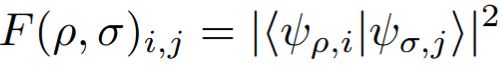

Finally, we will retrieve the **10 most similar samples** from the database for each subdivision of the input sample, based on the similarity metric. These results will help identify the closest matches for each part of the input track.

⚠️ **Note:** This process might take several minutes to complete.


In [22]:
from Main import exec_multiple

#Load the bundle
database_bundle, track_names = load_database_bundle()

NUM_BANDS = 3  # Number of frequency bands
SPINE_QUBITS = 3  # Number of subdivisions for quantum encoding
ENCODING_METHOD = 'pkbse'  # Encoding method for circuits: 'pkbse' or 'static'

BAND_MAPPING = subB[NUM_BANDS]

input_folder = './Dataset'
output_folder = './Grids'
layers = 1
for layer in range(1,layers + 1):
    exec_multiple(NUM_BANDS, BAND_MAPPING, SPINE_QUBITS, ENCODING_METHOD, database_bundle, track_names, input_folder, output_folder, layer)



Database bundle loaded successfully from organized subfolders.
./Dataset/hiphop.00002.wav
Extracting features from test sample: ./Dataset/hiphop.00002.wav
[array([-2.01532383e-08, -2.22982758e-07, -1.23909631e-06, ...,
       -7.13667067e-03, -4.84458033e-03, -2.68183104e-03]), array([-1.08203801e-07, -1.10331506e-06, -5.54126144e-06, ...,
       -9.25213825e-04, -1.23770291e-03, -1.50809444e-03]), array([-2.73732459e-05, -1.27369184e-03, -1.60949112e-03, ...,
       -1.05125648e-02, -8.08067825e-03,  1.31132863e-04])]
dict_keys(['000', '001', '010', '011', '100', '101', '110', '111'])
dict_keys(['000', '001', '010', '011', '100', '101', '110', '111'])
dict_keys(['000', '001', '010', '011', '100', '101', '110', '111'])
Feature extraction complete.
Encoding test sample into a quantum circuit...
check point... 0
check point... 1
check point... 2
check point... 3
check point... 0
check point... 1
check point... 2
check point... 3
check point... 0
check point... 1
check point... 2
check po

All the results are now saved in the **Grids** folder. Each grid corresponds to an individual input sample. Inside each grid, you will find:

- The **8 subdivisions** of the input sample.
- The **10 most similar samples** for each subdivision, retrieved from the database.
- The **probabilities** of each subdivision to sound.

This structured output allows for easy visualization and further analysis of the results.

## Step 4: Beat Reconstruction

The next step is to reconstruct the new beat. This involves performing a **weighted random sampling** of the subdivisions based on their assigned weights. From this sampling, we will select a specific number of samples to play for each subdivision, ultimately creating the reconstructed beat.



In [23]:
def sample_wav_files_from_json(file_path, size_random = 8,seed = None):

    if seed is not None:
        np.random.seed(seed)
    # Load the JSON file
    with open(file_path, 'r') as f:
        data = json.load(f)

    fidelity_grid = data["fidelity_grid"]
    prob = data["output_probs_test"]

    # Use numpy to sample subdivisions based on probabilities
    sampled_subdivisions = np.random.choice(
        list(fidelity_grid.keys()), size=size_random, replace=True, p=prob
    )

    sampled_files = {}
    print("Probabilities: ", prob)
    print("Sampled subdivisions: ", sampled_subdivisions)
    # Track available files for each subdivision
    available_files = {key: [item[0] for item in subdivision] for key, subdivision in fidelity_grid.items()}

    for subdivision in sampled_subdivisions:
        if available_files[subdivision]:
            # Assign the first file from the available list and remove it
            sampled_file = available_files[subdivision].pop(0)
            if subdivision not in sampled_files:
                sampled_files[subdivision] = []
            sampled_files[subdivision].append(sampled_file)

    sampled_files = {key: sampled_files[key] for key in sorted(sampled_files.keys(), key=int)}
    return sampled_files, prob, fidelity_grid

In [29]:
input_folder = './Grids'

for root, dirs, files in os.walk(input_folder):
        relative_path = os.path.relpath(root, input_folder)
        # Extract the genre from the relative path
        genre = os.path.basename(relative_path)
        if not genre:  # If the folder itself is the input root
            continue

        for file in files:
            file_path = os.path.join(root, file)
            print("File: ",file)

            # Process the file
            a, probab, grid = sample_wav_files_from_json(file_path, 8, 42)
            print(json.dumps(a, indent=4))
            print('-------------------------------------------------------------------------------')

File:  hiphop.00091
Probabilities:  [0.09977882202085361, 0.221382427452527, 0.06573618701793957, 0.14585095673371662, 0.08751188272784455, 0.19416538135900255, 0.05765449393747376, 0.12791984875064316]
Sampled subdivisions:  ['2' '7' '5' '4' '1' '1' '0' '6']
{
    "0": [
        "Pm_H1.wav"
    ],
    "1": [
        "Smt_H1.wav",
        "Sli_H1.wav"
    ],
    "2": [
        "Lo_Tom1.wav"
    ],
    "4": [
        "Lo_Tom1.wav"
    ],
    "5": [
        "Str_Oh1.wav"
    ],
    "6": [
        "Str_Oh1.wav"
    ],
    "7": [
        "Str_Crsh1.wav"
    ]
}
-------------------------------------------------------------------------------
File:  hiphop.00078
Probabilities:  [0.1042141302067377, 0.29286755884433574, 0.0404160644808105, 0.11357916742296997, 0.08489582204124449, 0.2385783205020212, 0.032924086311172024, 0.09252485019070635]
Sampled subdivisions:  ['1' '7' '5' '4' '1' '1' '0' '5']
{
    "0": [
        "Tab_05.wav"
    ],
    "1": [
        "Hi_Tom1.wav",
        "Slp_Bng.wav"

At this stage, we can observe that each file contains its own **dictionary**, where:
- The samples are organized into their respective **subdivisions**.
- The dictionary specifies which sample should play in each subdivision of the measure.

The final step, **reconstructing the beat**, was carried out using external software. This choice was made to simplify the process of handling audio, which can become quite complex within a coding environment.

For the purposes of this code, the process concludes here, leaving us with a **dictionary** that clearly indicates which samples should sound in each subdivision of the measure.
